In [1]:
%matplotlib widget

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from tqdm.autonotebook import trange, tqdm
import torch
import matplotlib.patches as patches
from torch.profiler import profile, record_function, ProfilerActivity
from typing import Optional, List
import math

In [2]:
from torch.utils.cpp_extension import load
neighborSearch_cpp = load(name="neighborSearch", 
        sources=["neighborhood.cpp"], 
        verbose=True, extra_cflags=['-fopenmp', '-O0', '-march=native', '-std=c++17'], extra_ldflags=['-fopenmp'])

Using /home/winchenbach/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Emitting ninja build file /home/winchenbach/.cache/torch_extensions/py310_cu121/neighborSearch/build.ninja...
Building extension module neighborSearch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] c++ -MMD -MF neighborhood.o.d -DTORCH_EXTENSION_NAME=neighborSearch -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/include -isystem /home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/include/TH -isystem /home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/include/THC -isystem /home/winchenbach/anaconda3/envs/torch2/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -fopenmp -O0 -march=native -std=c++17 -c /home/winchenbach/dev/diffSPH/neighborhood.cpp -o neighborhood.o 
[2/2] c++ neighborhood.o -shared -fopenmp -L/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/lib -lc10 -ltorch_cpu -ltorch -ltorch_python -o neighb

Loading extension module neighborSearch...


In [3]:
@torch.jit.script
def volumeToSupport(volume : float, targetNeighbors : int, dim : int):
    """
    Calculates the support radius based on the given volume, target number of neighbors, and dimension.

    Parameters:
    volume (float): The volume of the support region.
    targetNeighbors (int): The desired number of neighbors.
    dim (int): The dimension of the space.

    Returns:
    torch.Tensor: The support radius.
    """
    if dim == 1:
        # N_h = 2 h / v -> h = N_h * v / 2
        return targetNeighbors * volume / 2
    elif dim == 2:
        # N_h = \pi h^2 / v -> h = \sqrt{N_h * v / \pi}
        return torch.sqrt(targetNeighbors * volume / np.pi)
    else:
        # N_h = 4/3 \pi h^3 / v -> h = \sqrt[3]{N_h * v / \pi * 3/4}
        return torch.pow(targetNeighbors * volume / np.pi * 3 /4, 1/3)
@torch.jit.script
def compute_h(qMin, qMax, referenceSupport : float): 
    """
    Compute the smoothing length (h) based on the given minimum and maximum coordinates (qMin and qMax)
    and the reference support value. The smoothing length is used for grid operations and is determined
    by dividing the domain into cells based on the reference support value such that h > referenceSupport.

    Args:
        qMin (torch.Tensor): The minimum coordinates.
        qMax (torch.Tensor): The maximum coordinates.
        referenceSupport (float): The reference support value.

    Returns:
        torch.Tensor: The computed smoothing length (h).
    """
    qExtent = qMax - qMin
    numCells = torch.floor(qExtent / referenceSupport)
    h = qExtent / numCells
    return torch.max(h)
@torch.jit.script
def getDomainExtents(positions, minDomain : Optional[torch.Tensor], maxDomain : Optional[torch.Tensor]):
    """
    Calculates the domain extents based on the given positions and optional minimum and maximum domain values.

    Args:
        positions (torch.Tensor): The positions of the particles.
        minDomain (Optional[torch.Tensor]): Optional minimum domain values.
        maxDomain (Optional[torch.Tensor]): Optional maximum domain values.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: A tuple containing the minimum and maximum domain extents.
    """
    if minDomain is not None and isinstance(minDomain, list):
        minD = torch.tensor(minDomain).to(x.device).type(x.dtype)
    elif minDomain is not None:
        minD = minDomain
    else:
        minD = torch.min(positions, dim = 0)[0]
    if maxDomain is not None and isinstance(minDomain, list):
        maxD = torch.tensor(maxDomain).to(x.device).type(x.dtype)
    elif maxDomain is not None:
        maxD = maxDomain
    else:
        maxD = torch.max(positions, dim = 0)[0]
    return minD, maxD

In [4]:
@torch.jit.script
def sortReferenceParticles(referenceParticles, referenceSupport : float, domainMin, domainMax):
    """
    Sorts the reference particles based on their positions within a given domain.

    Args:
        referenceParticles (torch.Tensor): Tensor containing the reference particles' positions.
        referenceSupport (float): The support radius for the reference particles.
        domainMin (torch.Tensor): Tensor containing the minimum coordinates of the domain.
        domainMax (torch.Tensor): Tensor containing the maximum coordinates of the domain.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, float]: 
        A tuple containing the sorted linear indices, sorting indices, cell count, domain minimum, 
        domain maximum, and the computed hCell value.
    """
    with record_function("sort"): 
        with record_function("sort - index Calculation"): 
            hCell = compute_h(domainMin, domainMax, referenceSupport)
            qExtent = domainMax - domainMin
            cellCount = torch.ceil(qExtent / (hCell)).to(torch.int32)
            indices = torch.floor((referenceParticles - domainMin) / hCell).to(torch.int32)
            linearIndices = indices[:,0] + cellCount[0] * indices[:,1]
        with record_function("sort - actual argsort"): 
            sortingIndices = torch.argsort(linearIndices)
        with record_function("sort - sorting data"): 
            sortedLinearIndices = linearIndices[sortingIndices]
    return sortedLinearIndices, sortingIndices, \
            cellCount, domainMin, domainMax, float(hCell)
@torch.jit.script
def hashCellIndices(cellIndices, hashMapLength : int):
    """
    Hashes the cell indices using a hash function.

    Args:
        cellIndices (torch.Tensor): Tensor containing the cell indices.
        hashMapLength (int): Length of the hash map.

    Returns:
        torch.Tensor: Hashed cell indices.

    Raises:
        ValueError: If the dimension of cellIndices is not 1, 2, or 3.
    """
    primes = [73856093, 19349663, 83492791] # arbitrary primes but they should be large and different and these have been used in literature before
    if cellIndices.shape[1] == 1:
        return cellIndices % hashMapLength
    elif cellIndices.shape[1]  == 2:
        return (cellIndices[:,0] * primes[0] + cellIndices[:,1] * primes[1]) % hashMapLength
    elif cellIndices.shape[1]  == 3:
        return (cellIndices[:,0] * primes[0] + cellIndices[:,1] * primes[1] + cellIndices[:,2] * primes[2]) % hashMapLength
    else: 
        raise ValueError('Only 1D, 2D and 3D supported')
@torch.jit.script
def computeGridSupport(queryParticleSupports : Optional[torch.Tensor], referenceSupports : Optional[torch.Tensor], mode : str = 'symmetric'):  
    """
    Computes the maximum support value for a grid based on the given query particle supports and reference supports.
    
    Args:
        queryParticleSupports (Optional[torch.Tensor]): Tensor containing the support values for query particles.
        referenceSupports (Optional[torch.Tensor]): Tensor containing the support values for reference particles.
        mode (str, optional): The mode for computing the grid support. Can be 'scatter', 'gather', or 'symmetric'. 
            Defaults to 'symmetric'.
    
    Returns:
        torch.Tensor: The maximum support value for the grid.
    
    Raises:
        ValueError: If the mode is not one of 'scatter', 'gather', or 'symmetric'.
        AssertionError: If the required supports are not provided for the specified mode.
    """
    device = queryParticleSupports.device if queryParticleSupports is not None else (referenceSupports.device if referenceSupports is not None else torch.device('cpu'))
    dtype = queryParticleSupports.dtype if queryParticleSupports is not None else (referenceSupports.dtype if referenceSupports is not None else torch.float32)
    hMax = torch.tensor(0.0, device = device, dtype = dtype)
    if mode == 'scatter':
        assert referenceSupports is not None, 'referenceSupports must be provided for scatter mode'
        hMax = torch.max(referenceSupports) if referenceSupports is not None else 0.0
    elif mode == 'gather':
        assert queryParticleSupports is not None, 'queryParticleSupports must be provided for gather mode'
        hMax = torch.max(queryParticleSupports) if queryParticleSupports is not None else 0.0
    elif mode == 'symmetric':
        assert referenceSupports is not None, 'referenceSupports must be provided for symmetric mode'
        assert queryParticleSupports is not None, 'queryParticleSupports must be provided for symmetric mode'
        referenceHMax = torch.max(referenceSupports) if referenceSupports is not None else 0.0
        queryHMax = torch.max(queryParticleSupports) if queryParticleSupports is not None else 0.0
        hMax = torch.max(referenceHMax, queryHMax)
    else:
        raise ValueError('mode must be one of scatter, gather or symmetric')
    return hMax
@torch.jit.script
def countUniqueEntries(indices, positions):
    """
    Count the number of unique entries in the indices tensor and return the unique indices and their counts.

    Args:
        indices (torch.Tensor): Tensor containing the indices.
        positions (torch.Tensor): Tensor containing the positions.

    Returns:
        tuple: A tuple containing the unique indices and their counts.
    """
    ii, nit = torch.unique(indices, return_counts=True)
    ni = torch.zeros(positions.shape[0], dtype=nit.dtype, device=positions.device)
    ni[ii] = nit
    return ii, ni

In [5]:
@torch.jit.script
def buildCompactHashMap(x, minDomain, maxDomain, periodicity : List[bool], hMax : float, hashMapLength : int):
    """Builds a compact hash map for efficient neighborhood search.

    Args:
        x (torch.Tensor): The positions of the particles.
        minDomain (float): The minimum domain extent.
        maxDomain (float): The maximum domain extent.
        periodicity (List[bool]): A list indicating whether each dimension is periodic or not.
        hMax (float): The maximum support radius.
        hashMapLength (int): The length of the hash map.

    Returns:
        tuple: A tuple containing the following elements:
            - sortedPositions (torch.Tensor): The sorted positions of the particles.
            - hashTable (torch.Tensor): The hash table containing the start and length for each cell in the hash map.
            - sortedCellTable (torch.Tensor): The sorted cell table containing information about each cell.
            - hCell (float): The cell size.
            - qMin (torch.Tensor): The minimum coordinates of the domain.
            - qMax (torch.Tensor): The maximum coordinates of the domain.
            - numCells (int): The total number of cells.
            - sortIndex (torch.Tensor): The sort index used for sorting the particles.
    """
    # Compute domain extents
    minD, maxD = getDomainExtents(x, minDomain, maxDomain)
    # Sort the particles (and supports) based on a linear index
    # Returns only a key
    sortedLinear, sortIndex, numCells, qMin, qMax, hCell = sortReferenceParticles(x, hMax, minD, maxD)
    # Do the actual resort
    sortedPositions = x[sortIndex,:]
    # sortedSupports = xSupport[sortIndex]
    
    # compact teh list of occupied cells
    cellIndices, cellCounters = torch.unique_consecutive(sortedLinear, return_counts=True, return_inverse=False)
    cellCounters = cellCounters.to(torch.int32)
    # Needs to zero padded for the indexing to work properly as the 0th cell is valid and cumsum doesn't include the first element

    cumCell = torch.hstack((torch.tensor([0], device = cellIndices.device, dtype=cellCounters.dtype),torch.cumsum(cellCounters,dim=0)))[:-1]#.to(torch.int32)

    # We can now use the cumCell to index into the sortedIndices to get the cell index for each particle
    # We could have reversed the linear indices to get the cell index for each cell, but this is more reliable and avoids inverse computations
    sortedIndices = torch.floor((sortedPositions - qMin) / hCell).to(torch.int32)
    cellGridIndices = sortedIndices[cumCell,:]
    # Cell indices contains the linear indices of the particles in each cell
    # cellCounters contains the number of particles in each cell
    # cumCell contains the cumulative sum of the number of particles in each cell, i.e., the offset into the cell
    # With this information we can build a datastructure with [begin, end) for each cell using cellCounters and cumCell!
    cellTable = torch.stack((cellIndices, cumCell, cellCounters), dim = 1)

    # Hash the cell indices and sort them to get a compact list of occupied cells with unique_consecutive, same as for the cells
    hashedIndices = hashCellIndices(cellGridIndices, hashMapLength)
    hashIndexSorting = torch.argsort(hashedIndices)
    hashMap, hashMapCounters = torch.unique_consecutive(hashedIndices[hashIndexSorting], return_counts=True, return_inverse=False)
    hashMapCounters = hashMapCounters.to(torch.int32)
    # Resort the entries based on the hashIndexSorting so they can be accessed through the hashmap
    sortedCellIndices = cellIndices[hashIndexSorting]
    sortedCellTable = torch.stack([c[hashIndexSorting] for c in cellTable.unbind(1)], dim = 1)
    # print(sortedCellTable)
    # sortedCumCell = cellCounters[hashIndexSorting]
    # cellSpan = cellTable[hashIndexSorting,0][hashIndexSorting]

    # Same construction as for the cell list but this time we create a more direct table
    # The table contains the start and length for each cell in the hash table and -1 if the cell is empty
    hashTable = hashMap.new_ones(hashMapLength,2) * -1
    hashTable[:,1] = 0
    hashMap64 = hashMap.to(torch.int64)
    hashTable[hashMap64,0] = torch.hstack((torch.tensor([0], device = sortedCellIndices.device, dtype=sortedCellIndices.dtype),torch.cumsum(hashMapCounters,dim=0)))[:-1].to(torch.int32) #torch.cumsum(hashMapCounters, dim = 0) #torch.arange(hashMap.shape[0], device=hashMap.device)

    hashTable[hashMap64,1] = hashMapCounters

    return sortedPositions, hashTable, sortedCellTable, hCell, qMin,qMax, numCells, sortIndex


In [6]:
from typing import Tuple, List

@torch.jit.script
def queryCell(cellIndex, hashTable, hashMapLength : int, numCells, cellTable):
    # print('cellIndex:', cellIndex)
    linearIndex = cellIndex[0] + numCells[0] * cellIndex[1]
    # print('linearIndex:', linearIndex)
    hashedIndex = hashCellIndices(cellIndex.view(-1,cellIndex.shape[0]), hashMapLength)
    # print('hashedIndex:', hashedIndex)

    tableEntry = hashTable[hashedIndex,:]
    # print(tableEntry)
    hBegin = tableEntry[:,0][0]
    hLength = tableEntry[:,1][0]
    # print('hBegin:', hBegin, 'hLength:', hLength)

    if hBegin != -1:
        cell = cellTable[hBegin:hBegin + hLength]
        # cellEntries = cellSpan[hBegin:hBegin + hLength]
        # cellLengths = sortedCumCell[hBegin:hBegin + hLength]
        # cellLinearIndices = sortedCellIndices[hBegin:hBegin + hLength]
        # print('cellEntries:', cell[:,1])
        # print('cellLengths:', cell[:,2])
        # print('cellLinearIndices:', cell[:,0])
        if torch.isin(cell[:,0], linearIndex):
            # print('found')
            # print('cell', cell)
            cBegin = cell[cell[:,0] == linearIndex, 1][0]
            cLength = cell[cell[:,0] == linearIndex, 2][0]
            particlesInCell = torch.arange(cBegin, cBegin + cLength, device = linearIndex.device, dtype = linearIndex.dtype)
            # print(particlesInCell)
            return particlesInCell

    return torch.empty(0, dtype = linearIndex.dtype, device = linearIndex.device)



@torch.jit.script
def findNeighbors(queryPosition, querySupport: Optional[torch.Tensor], 
            searchRange : int, sortedPositions, sortedSupport: Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, 
            cellTable, qMin, hCell : float, maxDomain, minDomain, periodicity, mode : str):
    centerCell = torch.floor((queryPosition - qMin) / hCell).to(torch.int32)
    neighborhood = []
    for xx in range(-searchRange,searchRange + 1):
        for yy in range(-searchRange,searchRange + 1):
            cellIndex = centerCell + torch.tensor([xx,yy], device = centerCell.device, dtype = centerCell.dtype)
            cellIndex = cellIndex % numCells
            particlesInCell = queryCell(cellIndex, hashTable, hashMapLength, numCells, cellTable)
            # print('offset:', xx, yy, 'cellIndex:', cellIndex, 'particlesInCell:', particlesInCell)

            if particlesInCell.numel() > 0:
                referencePositions = sortedPositions[particlesInCell,:]
                # referenceSupports = sortedSupport[particlesInCell]

                
                if torch.any(periodicity):
                    distances = []
                    for i in range(queryPosition.shape[0]):
                        if periodicity[i]:
                            domainLength = (maxDomain[i] - minDomain[i])
                            distances.append((referencePositions[:,i] - queryPosition[i] + domainLength/2) % domainLength - domainLength/2)
                            # print('.')
                        else:
                            distances.append(referencePositions[:,i] - queryPosition[i])
                    relPositions = torch.stack(distances, dim = 1)
                    # print(relPositions)
                else:
                    relPositions = referencePositions - queryPosition
                # print(relPositions)
                # print(particlesInCell)
                    # domainLength = (maxDomain - minDomain)
                # relPosition = (relPosition + domainLength/2) % domainLength - domainLength/2
                distances = torch.norm(relPositions, dim=1, p=2)
                if mode == 'scatter' and sortedSupport is not None:
                    hij = sortedSupport[particlesInCell]
                    neighbors = particlesInCell[distances < hij]
                    neighborhood.append(neighbors)
                    # neighborhood[counter:counter + neighbors.numel()] = neighbors
                    # counter += neighbors.numel()
                elif mode == 'gather' and querySupport is not None:
                    hij = querySupport
                    neighbors = particlesInCell[distances < hij]
                    neighborhood.append(neighbors)
                    # neighborhood[counter:counter + neighbors.numel()] = neighbors
                    # counter += neighbors.numel()
                elif mode == 'symmetric' and querySupport is not None and sortedSupport is not None:
                    hij = (sortedSupport[particlesInCell] + querySupport) / 2
                    neighbors = particlesInCell[distances < hij]
                    neighborhood.append(neighbors)
                    # neighborhood[counter:counter + neighbors.numel()] = neighbors
                    # counter += neighbors.numel()
                # print('offset:', xx, yy, distances)
                # neighbors = particlesInCell[distances < querySupport]
                # neighborhood.append(neighbors)
    if len(neighborhood) > 0:
        return torch.hstack(neighborhood)
    return torch.empty(0, dtype = centerCell.dtype, device = centerCell.device)


@torch.jit.script
def findNeighborsFixed(queryPosition, querySupport : Optional[torch.Tensor], 
            searchRange : int, sortedPositions, sortedSupport : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, 
            cellTable, qMin, hCell : float, maxDomain, minDomain, periodicity, bufferSize: int, mode : str):
    centerCell = torch.floor((queryPosition - qMin) / hCell).to(torch.int32)
    neighborhood = torch.zeros(bufferSize, dtype = centerCell.dtype, device = centerCell.device)
    counter = 0
    for xx in range(-searchRange,searchRange + 1):
        for yy in range(-searchRange,searchRange + 1):
            cellIndex = centerCell + torch.tensor([xx,yy], device = centerCell.device, dtype = centerCell.dtype)
            cellIndex = cellIndex % numCells
            particlesInCell = queryCell(cellIndex, hashTable, hashMapLength, numCells, cellTable)

            if particlesInCell.numel() > 0:
                referencePositions = sortedPositions[particlesInCell,:]
                # referenceSupports = sortedSupport[particlesInCell]

                
                if torch.any(periodicity):
                    distances = []
                    for i in range(queryPosition.shape[0]):
                        if periodicity[i]:
                            domainLength = (maxDomain[i] - minDomain[i])
                            distances.append((referencePositions[:,i] - queryPosition[i] + domainLength/2) % domainLength - domainLength/2)
                        else:
                            distances.append(referencePositions[:,i] - queryPosition[i])
                    relPositions = torch.stack(distances, dim = 1)
                else:
                    relPositions = referencePositions - queryPosition

                distances = torch.norm(relPositions, dim=1, p=2)
                if mode == 'scatter' and sortedSupport is not None:
                    hij = sortedSupport[particlesInCell]
                    neighbors = particlesInCell[distances < hij]
                    neighborhood[counter:counter + neighbors.numel()] = neighbors
                    counter += neighbors.numel()
                elif mode == 'gather' and querySupport is not None:
                    hij = querySupport
                    neighbors = particlesInCell[distances < hij]
                    neighborhood[counter:counter + neighbors.numel()] = neighbors
                    counter += neighbors.numel()
                elif mode == 'symmetric' and querySupport is not None and sortedSupport is not None:
                    hij = (sortedSupport[particlesInCell] + querySupport) / 2
                    neighbors = particlesInCell[distances < hij]
                    neighborhood[counter:counter + neighbors.numel()] = neighbors
                    counter += neighbors.numel()

    return neighborhood[:counter]



@torch.jit.script
def countNeighbors(queryPosition, querySupport : Optional[torch.Tensor], 
            searchRange : int, sortedPositions, sortedSupport : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, 
            cellTable, qMin, hCell : float, maxDomain, minDomain, periodicity, mode : str):
    centerCell = torch.floor((queryPosition - qMin) / hCell).to(torch.int32)
    counter = torch.tensor(0, dtype = centerCell.dtype, device = centerCell.device)
    for xx in range(-searchRange,searchRange + 1):
        for yy in range(-searchRange,searchRange + 1):
            cellIndex = centerCell + torch.tensor([xx,yy], device = centerCell.device, dtype = centerCell.dtype)
            cellIndex = cellIndex % numCells
            particlesInCell = queryCell(cellIndex, hashTable, hashMapLength, numCells, cellTable)
            # print('offset:', xx, yy, 'cellIndex:', cellIndex, 'particlesInCell:', particlesInCell)

            if particlesInCell.numel() > 0:
                referencePositions = sortedPositions[particlesInCell,:]
                # referenceSupports = sortedSupport[particlesInCell]

                
                if torch.any(periodicity):
                    distances = []
                    for i in range(queryPosition.shape[0]):
                        if periodicity[i]:
                            domainLength = (maxDomain[i] - minDomain[i])
                            distances.append((referencePositions[:,i] - queryPosition[i] + domainLength/2) % domainLength - domainLength/2)
                            # print('.')
                        else:
                            distances.append(referencePositions[:,i] - queryPosition[i])
                    relPositions = torch.stack(distances, dim = 1)
                    # print(relPositions)
                else:
                    relPositions = referencePositions - queryPosition
                # print(relPositions)
                # print(particlesInCell)
                    # domainLength = (maxDomain - minDomain)
                # relPosition = (relPosition + domainLength/2) % domainLength - domainLength/2
                distances = torch.norm(relPositions, dim=1, p=2)
                # print('offset:', xx, yy, distances)
                if mode == 'scatter' and sortedSupport is not None:
                    hij = sortedSupport[particlesInCell]
                    counter += torch.sum(distances < hij)
                elif mode == 'gather' and querySupport is not None:
                    hij = querySupport
                    counter += torch.sum(distances < hij)
                elif mode == 'symmetric' and querySupport is not None and sortedSupport is not None:
                    hij = (sortedSupport[particlesInCell] + querySupport) / 2
                    counter += torch.sum(distances < hij)
                # neighbors = particlesInCell[distances < querySupport]
                # neighborhood.append(neighbors)
    return counter

In [7]:
@torch.jit.script
def buildNeighborOffsetList(queryPositions, queryParticleSupports : Optional[torch.Tensor], sortedPositions, sortedSupports : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, sortedCellTable, qMin, hCell : float, maxD, minD, periodicity : List[bool], mode : str):
    """
    Builds the neighbor offset list for each query particle.

    Args:
        queryPositions (torch.Tensor): Tensor containing the positions of the query particles.
        queryParticleSupports (Optional[torch.Tensor]): Tensor containing the support values for each query particle. Default is None.
        sortedPositions (torch.Tensor): Tensor containing the sorted positions of all particles.
        sortedSupports (Optional[torch.Tensor]): Tensor containing the sorted support values for all particles. Default is None.
        hashTable: The hash table used for spatial hashing.
        hashMapLength (int): The length of the hash map.
        numCells: The number of cells in the spatial grid.
        sortedCellTable: The sorted cell table.
        qMin: The minimum query position.
        hCell (float): The cell size.
        maxD: The maximum distance.
        minD: The minimum distance.
        periodicity (List[bool]): List indicating the periodicity of each dimension.
        mode (str): The mode of the neighbor search.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, int]: A tuple containing the neighbor counter, neighbor offsets, and neighbor list length.
    """
    neighborCounter = torch.zeros(queryPositions.shape[0], dtype = torch.int32)
    for index in range(queryPositions.shape[0]):
        neighborCounter[index] = countNeighbors(queryPositions[index,:], queryParticleSupports[index] if queryParticleSupports is not None else None, 1, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity), mode)

    neighborOffsets = torch.hstack((torch.tensor([0], dtype = torch.int32, device = queryPositions.device), torch.cumsum(neighborCounter, dim = 0)))[:-1]
    neighborListLength = neighborOffsets[-1] + neighborCounter[-1]

    return neighborCounter, neighborOffsets, neighborListLength

@torch.jit.script
def buildNeighborListFixed(neighborListLength, sortIndex, queryPositions, queryParticleSupports : Optional[torch.Tensor], sortedPositions, sortedSupports : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, sortedCellTable, qMin, hCell : float, maxD, minD, periodicity: List[bool], neighborCounter, neighborOffsets, mode : str):
    """
    Builds a fixed-size neighbor list for each query particle.

    Args:
        neighborListLength (int): The length of the neighbor list.
        sortIndex (torch.Tensor): The sorted index of particles.
        queryPositions (torch.Tensor): The positions of query particles.
        queryParticleSupports (Optional[torch.Tensor]): The supports of query particles.
        sortedPositions (torch.Tensor): The sorted positions of particles.
        sortedSupports (Optional[torch.Tensor]): The sorted supports of particles.
        hashTable: The hash table for spatial hashing.
        hashMapLength (int): The length of the hash map.
        numCells: The number of cells in the spatial grid.
        sortedCellTable: The sorted cell table.
        qMin: The minimum query position.
        hCell (float): The cell size.
        maxD: The maximum distance.
        minD: The minimum distance.
        periodicity (List[bool]): The periodicity of the system.
        neighborCounter: The counter for neighbors.
        neighborOffsets: The offsets for neighbors.
        mode (str): The mode for finding neighbors.

    Returns:
        torch.Tensor: The indices of query particles.
        torch.Tensor: The indices of neighbor particles.
    """
    i = torch.zeros(neighborListLength, dtype = sortIndex.dtype, device = queryPositions.device)
    j = torch.zeros(neighborListLength, dtype = sortIndex.dtype, device = queryPositions.device)
    for index in range(queryPositions.shape[0]):
        neighborhood = findNeighborsFixed(queryPositions[index,:], queryParticleSupports[index] if queryParticleSupports is not None else None, 1, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity), bufferSize = neighborCounter[index], mode =  mode)
        
        i[neighborOffsets[index]:neighborOffsets[index] + neighborCounter[index]] = index
        j[neighborOffsets[index]:neighborOffsets[index] + neighborCounter[index]] = sortIndex[neighborhood]

    return i, j

@torch.jit.script
def buildNeighborListDynamic(sortIndex, queryPositions, queryParticleSupports : Optional[torch.Tensor], sortedPositions, sortedSupports : Optional[torch.Tensor], hashTable, hashMapLength:int, numCells, sortedCellTable, qMin, hCell : float, maxD, minD, periodicity: List[bool],mode : str):
    """
    Builds a dynamic neighbor list for each query particle based on its position and support radius.

    Args:
        sortIndex (torch.Tensor): The sorted index of particles.
        queryPositions (torch.Tensor): The positions of query particles.
        queryParticleSupports (Optional[torch.Tensor]): The support radius of query particles. Default is None.
        sortedPositions (torch.Tensor): The sorted positions of particles.
        sortedSupports (Optional[torch.Tensor]): The support radius of particles. Default is None.
        hashTable: The hash table for spatial hashing.
        hashMapLength (int): The length of the hash map.
        numCells: The number of cells in the spatial grid.
        sortedCellTable: The sorted cell table.
        qMin: The minimum query particle position.
        hCell (float): The cell size.
        maxD: The maximum distance for neighbor search.
        minD: The minimum distance for neighbor search.
        periodicity (List[bool]): The periodicity of the system in each dimension.
        mode (str): The mode of neighbor search.

    Returns:
        torch.Tensor: The indices of query particles.
        torch.Tensor: The indices of neighbor particles.
    """
    # dynamic size approach
    i = []
    j = []

    for index in range(queryPositions.shape[0]):
        neighborhood = findNeighbors(queryPositions[index,:], queryParticleSupports[index] if queryParticleSupports is not None else None, 1, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity), mode)
        i.append(torch.ones(neighborhood.shape[0], dtype = torch.int32) * index)
        j.append(neighborhood)

    i = torch.hstack(i)
    j = sortIndex[torch.hstack(j)]

    return i, j


In [24]:
@torch.jit.script
def neighborSearch(
    queryPositions, queryParticleSupports : Optional[torch.Tensor], 
    referencePositions, referenceSupports : Optional[torch.Tensor], 
    minDomain : Optional[torch.Tensor], maxDomain : Optional[torch.Tensor], periodicity : List[bool], hashMapLength : int, mode : str = 'symmetric'):
    """
    Perform neighbor search for particles in a given domain.

    Args:
        queryPositions (torch.Tensor): Positions of query particles.
        queryParticleSupports (Optional[torch.Tensor]): Supports of query particles.
        referencePositions (torch.Tensor): Positions of reference particles.
        referenceSupports (Optional[torch.Tensor]): Supports of reference particles.
        minDomain (Optional[torch.Tensor]): Minimum domain extents.
        maxDomain (Optional[torch.Tensor]): Maximum domain extents.
        periodicity (List[bool]): List of booleans indicating periodic boundaries.
        hashMapLength (int): Length of the hash map.
        mode (str, optional): Mode of neighbor search. Defaults to 'symmetric'.

    Returns:
        Tuple: A tuple containing the following elements:
            - (i, j) (Tuple[torch.Tensor, torch.Tensor]): Indices of neighboring particles.
            - ni (torch.Tensor): Number of neighbors per query particle.
            - nj (torch.Tensor): Number of neighbors per reference particle.
            - sortedPositions (torch.Tensor): Sorted positions of reference particles.
            - sortedSupports (Optional[torch.Tensor]): Sorted supports of reference particles.
            - hashTable (torch.Tensor): Hash table for neighbor search.
            - sortedCellTable (torch.Tensor): Sorted cell table for neighbor search.
            - hCell (torch.Tensor): Cell size for neighbor search.
            - qMin (torch.Tensor): Minimum domain extent.
            - qMax (torch.Tensor): Maximum domain extent.
            - numCells (torch.Tensor): Number of cells in the domain.
            - sortIndex (torch.Tensor): Sorted indices of reference particles.
    """
    with record_function("neighborSearch"):
        with record_function("neighborSearch - computeGridSupport"):
            # Compute grid support
            hMax = computeGridSupport(queryParticleSupports, referenceSupports, mode)
        with record_function("neighborSearch - getDomainExtents"):
            # Compute domain extents
            minD, maxD = getDomainExtents(referencePositions, minDomain, maxDomain)
        with record_function("neighborSearch - sortReferenceParticles"): 
            # Wrap x positions around periodic boundaries
            x = torch.vstack([component if not periodic else torch.remainder(component - minD[i], maxD[i] - minD[i]) + minD[i] for i, (component, periodic) in enumerate(zip(referencePositions.mT, periodicity))]).mT
            # print(x.min(), x.max())
            # Build hash table and cell table
            sortedPositions, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = buildCompactHashMap(x, minD, maxD, periodicity, hMax, hashMapLength)
            sortedSupports = referenceSupports[sortIndex] if referenceSupports is not None else None
        with record_function("neighborSearch - buildNeighborOffsetList"):
            # Build neighbor list by first building a list of offsets and then the actual neighbor list
            neighborCounter, neighborOffsets, neighborListLength = buildNeighborOffsetList(queryPositions, queryParticleSupports, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, periodicity, mode)
        with record_function("neighborSearch - buildNeighborListFixed"):
            i,j = buildNeighborListFixed(neighborListLength, sortIndex, queryPositions, queryParticleSupports, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, periodicity, neighborCounter, neighborOffsets, mode)
        with record_function("neighborSearch - countUniqueEntries"):        
            # compute number of neighbors per particle for convenience
            ii, ni = countUniqueEntries(i, queryPositions)
            jj, nj = countUniqueEntries(j, referencePositions)

    return (i,j), ni, nj, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex


In [25]:
nx = 32
dim = 2

minDomain = torch.tensor([-1] * dim, dtype = torch.float32)
maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32)
# maxDomain = torch.tensor([ 2, 1], dtype = torch.float32)
periodicity = [True] * dim

extent = maxDomain - minDomain
shortExtent = torch.min(extent, dim = 0)[0]
dx = shortExtent / nx
h = volumeToSupport(dx**dim, 50, dim)

positions = []
for d in range(dim):
    positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, nx))
grid = torch.meshgrid(*positions, indexing = 'xy')
positions = torch.stack(grid, dim = -1).reshape(-1,dim)
# enable for random positions for alternative debugging
# positions = torch.rand(nx**dim, dim) * 2 - 1

supports = torch.ones(positions.shape[0]) * h

print('positions:', positions.shape, positions.min(), positions.max())
print('supports:', supports.shape, supports.min(), supports.max())

ny = 16
# h = 0.1

# positions = torch.rand(n, 2) * 0.5 + 0.25
dy = dx.item()

xpos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
ypos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
xpos2, ypos2 = torch.meshgrid(xpos2, ypos2, indexing = 'xy')
y = torch.stack((xpos2.flatten(), ypos2.flatten()), dim = 1)
# y = torch.clone(positions)
ySupport = torch.ones(y.shape[0]) * supports[0]

periodicity = [False] * dim
hashMapLength = 4096

positions: torch.Size([1024, 2]) tensor(-0.9688) tensor(0.9688)
supports: torch.Size([1024]) tensor(0.2493) tensor(0.2493)


In [26]:
queryParticleSupports = ySupport
queryPositions = y
referenceSupports = supports
referencePositions = positions
mode = 'symmetric'

with record_function("neighborSearch"):
    with record_function("neighborSearch - computeGridSupport"):
        # Compute grid support
        hMax = computeGridSupport(queryParticleSupports, referenceSupports, mode)
    with record_function("neighborSearch - getDomainExtents"):
        # Compute domain extents
        minD, maxD = getDomainExtents(referencePositions, minDomain, maxDomain)
    with record_function("neighborSearch - sortReferenceParticles"): 
        # Wrap x positions around periodic boundaries
        
        x = torch.vstack([component if not periodic else torch.remainder(component - minD[i], maxD[i] - minD[i]) + minD[i] for i, (component, periodic) in enumerate(zip(referencePositions.mT, periodicity))]).mT
        print(x.min(), x.max())
        # Build hash table and cell table
        sortedPositions, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = buildCompactHashMap(x, minD, maxD, periodicity, hMax, hashMapLength)
        sortedSupports = referenceSupports[sortIndex] if referenceSupports is not None else None
    with record_function("neighborSearch - buildNeighborOffsetList"):
        # Build neighbor list by first building a list of offsets and then the actual neighbor list
        neighborCounter, neighborOffsets, neighborListLength = buildNeighborOffsetList(queryPositions, queryParticleSupports, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, periodicity, mode)
    

tensor(-0.9688) tensor(0.9688)


In [27]:
x = torch.vstack([component if not periodic else torch.remainder(component - minD[i], maxD[i] - minD[i]) + minD[i] for i, (component, periodic) in enumerate(zip(referencePositions.mT, periodicity))]).mT
print(x.min(), x.max())

print(x)
print(referencePositions)

tensor(-0.9688) tensor(0.9688)
tensor([[-0.9688, -0.9688],
        [-0.9062, -0.9688],
        [-0.8438, -0.9688],
        ...,
        [ 0.8438,  0.9688],
        [ 0.9062,  0.9688],
        [ 0.9688,  0.9688]])
tensor([[-0.9688, -0.9688],
        [-0.9062, -0.9688],
        [-0.8438, -0.9688],
        ...,
        [ 0.8438,  0.9688],
        [ 0.9062,  0.9688],
        [ 0.9688,  0.9688]])


In [28]:
print(sortedCellTable.shape, sortedCellTable[:,0])
print(hashTable[hashTable[:,0] != -1].shape)


torch.Size([64, 3]) tensor([ 0, 43, 31,  8, 51, 39, 16, 59,  4, 47, 24, 12, 55, 32, 20, 63, 40, 28,
        48, 36, 56,  1, 44,  9, 52, 17, 60,  5, 25, 13, 33, 21, 41, 29, 49, 37,
        57,  2, 45, 10, 53, 18, 61,  6, 26, 14, 34, 22, 42, 30, 50, 38, 58,  3,
        46, 11, 54, 19, 62,  7, 27, 15, 35, 23])
torch.Size([64, 2])


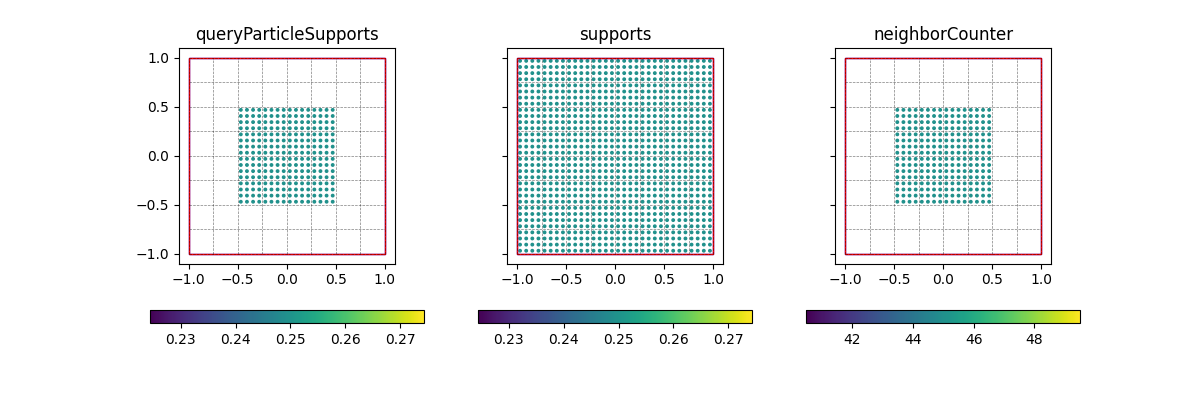

In [29]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


for i in range(numCells[0] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 100 / math.sqrt(positions.shape[0])

sc = axis[0,0].scatter(y[:,0], y[:,1], c = queryParticleSupports, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('queryParticleSupports')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')

sc = axis[0,1].scatter(positions[:,0], positions[:,1], c = supports, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('supports')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')

sc = axis[0,2].scatter(y[:,0], y[:,1], c = neighborCounter, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,2], orientation='horizontal')
axis[0,2].set_title('neighborCounter')
axis[0,2].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,2].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,2].set_aspect(1, adjustable='box')

In [30]:
searchRadius = 2
testDim = 2

offsets = torch.zeros(((1 + 2 * searchRadius)**testDim,testDim), dtype = torch.int32, device = queryPositions.device)
for d in range(testDim):
    itr = -searchRadius
    ctr = 0
    for o in range(offsets.shape[0]):
        c = o % ((searchRadius * 2 + 1) ** (d))
        if (c == 0 and ctr > 0):# or (ctr == 0 and d == 0):
            itr += 1
        if itr > searchRadius:
            itr = -searchRadius

        offsets[o,testDim - d - 1] = itr
        ctr += 1
        

# for d in range(testDim):
    # offsets[:,d] = torch.arange(-searchRadius,searchRadius + 1, device = queryPositions.device, dtype = torch.int32)

print('offsets:', offsets.shape, offsets)

# @torch.jit.script
def queryCell(cellIndex, hashTable, hashMapLength : int, numCells, cellTable):
    print('cellIndex:', cellIndex)
    linearIndex = cellIndex[0] + numCells[0] * cellIndex[1]
    print('linearIndex:', linearIndex)
    hashedIndex = hashCellIndices(cellIndex.view(-1,cellIndex.shape[0]), hashMapLength)
    print('hashedIndex:', hashedIndex)

    tableEntry = hashTable[hashedIndex,:]
    # print(tableEntry)
    hBegin = tableEntry[:,0][0]
    hLength = tableEntry[:,1][0]
    print('hBegin:', hBegin, 'hLength:', hLength)

    if hBegin != -1:
        cell = cellTable[hBegin:hBegin + hLength]
        # cellEntries = cellSpan[hBegin:hBegin + hLength]
        # cellLengths = sortedCumCell[hBegin:hBegin + hLength]
        # cellLinearIndices = sortedCellIndices[hBegin:hBegin + hLength]
        print('cellEntries:', cell[:,1])
        print('cellLengths:', cell[:,2])
        print('cellLinearIndices:', cell[:,0])
        if torch.isin(cell[:,0], linearIndex):
            print('found')
            print('cell', cell)
            cBegin = cell[cell[:,0] == linearIndex, 1][0]
            cLength = cell[cell[:,0] == linearIndex, 2][0]
            particlesInCell = torch.arange(cBegin, cBegin + cLength, device = linearIndex.device, dtype = linearIndex.dtype)
            print(particlesInCell)
            return particlesInCell

    return torch.empty(0, dtype = linearIndex.dtype, device = linearIndex.device)


queryPosition = queryPositions[0,:]
centerCell = torch.floor((queryPosition - qMin) / hCell).to(torch.int32)
queryCell(centerCell, hashTable, hashMapLength, numCells, sortedCellTable)

offsets: torch.Size([25, 2]) tensor([[-2, -2],
        [-2, -1],
        [-2,  0],
        [-2,  1],
        [-2,  2],
        [-1, -2],
        [-1, -1],
        [-1,  0],
        [-1,  1],
        [-1,  2],
        [ 0, -2],
        [ 0, -1],
        [ 0,  0],
        [ 0,  1],
        [ 0,  2],
        [ 1, -2],
        [ 1, -1],
        [ 1,  0],
        [ 1,  1],
        [ 1,  2],
        [ 2, -2],
        [ 2, -1],
        [ 2,  0],
        [ 2,  1],
        [ 2,  2]], dtype=torch.int32)
cellIndex: tensor([2, 2], dtype=torch.int32)
linearIndex: tensor(18, dtype=torch.int32)
hashedIndex: tensor([2552], dtype=torch.int32)
hBegin: tensor(41, dtype=torch.int32) hLength: tensor(1, dtype=torch.int32)
cellEntries: tensor([288])
cellLengths: tensor([16])
cellLinearIndices: tensor([18])
found
cell tensor([[ 18, 288,  16]])
tensor([288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
        302, 303], dtype=torch.int32)


tensor([288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
        302, 303], dtype=torch.int32)

In [31]:
neighborCounter

tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 

In [32]:
neighborCounter = torch.zeros(queryPositions.shape[0], dtype = torch.int32)
for index in range(queryPositions.shape[0]):
    neighborCounter[index] = countNeighbors(queryPositions[index,:], queryParticleSupports[index] if queryParticleSupports is not None else None, 1, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity), mode)

neighborOffsets = torch.hstack((torch.tensor([0], dtype = torch.int32, device = queryPositions.device), torch.cumsum(neighborCounter, dim = 0)))[:-1]
neighborListLength = neighborOffsets[-1] + neighborCounter[-1]


In [59]:
from torch.utils.cpp_extension import load
neighborSearch_cpp = load(name="neighborSearch", 
        sources=["neighborhood.cpp"], 
        verbose=True, extra_cflags=['-fopenmp', '-O0', '-march=native', '-std=c++17'], extra_ldflags=['-fopenmp'])

Using /home/winchenbach/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
The input conditions for extension module neighborSearch have changed. Bumping to version 5 and re-building as neighborSearch_v5...
Emitting ninja build file /home/winchenbach/.cache/torch_extensions/py310_cu121/neighborSearch/build.ninja...
Building extension module neighborSearch_v5...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] c++ -MMD -MF neighborhood.o.d -DTORCH_EXTENSION_NAME=neighborSearch_v5 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/include -isystem /home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/include/TH -isystem /home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/include/THC -isystem /home/winchenbach/anaconda3/envs/torch2/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -fopenmp -O0 -march=native -std=c++17 -c /home/winchenbach/dev/diffSPH/neighborhood.cpp -o neighborhood.o 
[2/2] c++ neighborhood.o -shared -fopenmp -L/home/winchenbach/anaconda3/envs/torch2/lib/python3.10/site-packages/torch/lib -lc10 -ltorch_cpu -ltorch -ltorch_python -o nei

Loading extension module neighborSearch_v5...


In [60]:
neighborCounter_cpp = neighborSearch_cpp.countNeighbors(
    queryPositions, queryParticleSupports if queryParticleSupports is not None else None, 1, 
    sortedPositions, sortedSupports, 
    hashTable, hashMapLength, 
    numCells, sortedCellTable, 
    qMin, hCell, maxD, minD, 
    torch.tensor(periodicity), mode, False)


neighborOffsets = torch.hstack((torch.tensor([0], dtype = torch.int32, device = queryPositions.device), torch.cumsum(neighborCounter_cpp, dim = 0).to(torch.int32)))[:-1]
neighborListLength = neighborOffsets[-1] + neighborCounter_cpp[-1]

neighbors_cpp = neighborSearch_cpp.buildNeighborList(
    neighborCounter_cpp, neighborOffsets, int(neighborListLength.item()),
    queryPositions, queryParticleSupports if queryParticleSupports is not None else None, 1, 
    sortedPositions, sortedSupports, 
    hashTable, hashMapLength, 
    numCells, sortedCellTable, 
    qMin, hCell, maxD, minD, 
    torch.tensor(periodicity), mode, False)

In [62]:
(i_cpu, j_cpu) = neighbors_cpp

ii, ni_cpu = countUniqueEntries(i_cpu, queryPositions)
jj, nj_cpu = countUniqueEntries(j_cpu, sortedPositions)

In [41]:
neighbors, ni, nj, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
    neighborSearch(y, ySupport, positions, supports, minDomain, maxDomain, periodicity, hashMapLength = 4096)

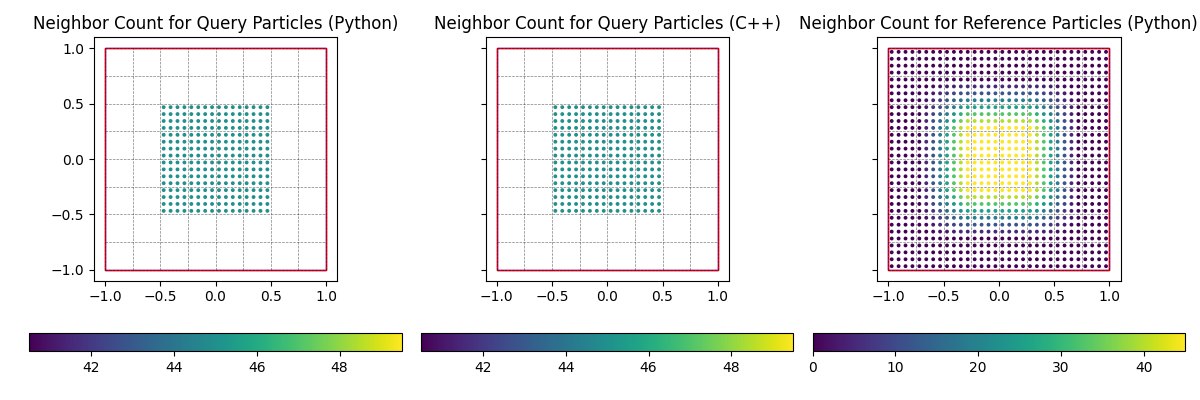

In [63]:
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


for i in range(numCells[0] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 100 / math.sqrt(positions.shape[0])

sc = axis[0,0].scatter(y[:,0], y[:,1], c = ni_cpu, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('Neighbor Count for Query Particles (Python)')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')


sc = axis[0,1].scatter(y[:,0], y[:,1], c = neighborCounter_cpp, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('Neighbor Count for Query Particles (C++)')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')

sc = axis[0,2].scatter(positions[:,0], positions[:,1], c = nj, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,2], orientation='horizontal')
axis[0,2].set_title('Neighbor Count for Reference Particles (Python)')
axis[0,2].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,2].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,2].set_aspect(1, adjustable='box')

fig.tight_layout()

In [18]:
# warm start for profiling
for i in tqdm(range(8)):
    neighbors, ni, nj, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
        neighborSearch(y, ySupport, positions, supports, minDomain, maxDomain, periodicity, hashMapLength = 4096)

  0%|          | 0/8 [00:00<?, ?it/s]

In [195]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=True, profile_memory=True) as prof:    
    neighbors, ni, nj, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = \
        neighborSearch(y, ySupport, positions, supports, minDomain, maxDomain, periodicity, hashMapLength = 4096)

# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

STAGE:2024-02-08 09:57:24 214603:214603 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-02-08 09:57:28 214603:214603 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-02-08 09:57:29 214603:214603 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [199]:

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=32))

--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                              neighborSearch         0.00%      36.000us       200.00%        6.616s        3.308s     487.02 Kb           0 b             2  
    neighborSearch - buildNeighborOffsetList        15.76%     521.232ms        50.59%        1.674s        1.674s       3.02 Kb      -1.13 Mb             1  
     neighborSearch - buildNeighborListFixed        16.03%     530.225ms        49.33%        1.632s        1.632s     176.98 Kb      -1.28 Mb             1  
                                 aten::index  

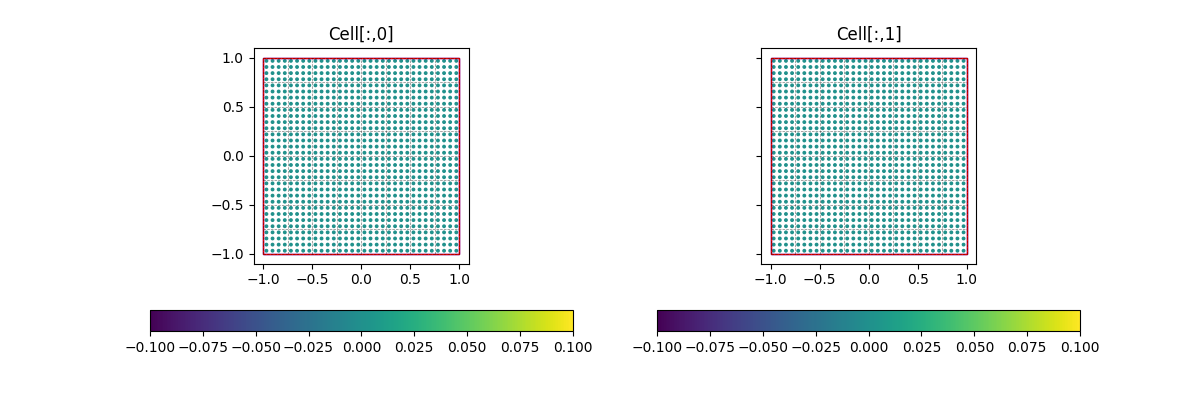

In [19]:
fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


for i in range(numCells[0] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 100 / math.sqrt(positions.shape[0])

sc = axis[0,0].scatter(y[:,0], y[:,1], c = ni, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('Cell[:,0]')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')

sc = axis[0,1].scatter(positions[:,0], positions[:,1], c = nj, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('Cell[:,1]')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')

In [72]:
nx = 32
dim = 2

minDomain = torch.tensor([-1] * dim, dtype = torch.float32)
maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32)
# maxDomain = torch.tensor([ 2, 1], dtype = torch.float32)
periodicity = [False] * dim

extent = maxDomain - minDomain
shortExtent = torch.min(extent, dim = 0)[0]
dx = shortExtent / nx
h = volumeToSupport(dx**dim, 50, dim)

positions = []
for d in range(dim):
    positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, nx))
grid = torch.meshgrid(*positions, indexing = 'xy')
positions = torch.stack(grid, dim = -1).reshape(-1,dim)
# enable for random positions for alternative debugging
positions = torch.rand(nx**dim, dim) * 0.5 + 0.25

supports = torch.ones(positions.shape[0]) * h

print('positions:', positions.shape, positions.min(), positions.max())
print('supports:', supports.shape, supports.min(), supports.max())

positions: torch.Size([1024, 2]) tensor(0.2505) tensor(0.7497)
supports: torch.Size([1024]) tensor(0.2493) tensor(0.2493)


In [73]:
# Wrap x positions around periodic boundaries
x = torch.vstack([component if not periodic else torch.remainder(component - minDomain[i], maxDomain[i] - minDomain[i]) + minDomain[i] for i, (component, periodic) in enumerate(zip(positions.mT, periodicity))]).mT
# Compute domain extents
minD, maxD = getDomainExtents(x, minDomain, maxDomain)

# Sort the particles (and supports) based on a linear index
# Returns only a key
sortedLinear, sortIndex, numCells, qMin, qMax, hCell = sortReferenceParticles(x, h, minD, maxD)
# Do the actual resort
sortedPositions = x[sortIndex,:]
sortedSupports = supports[sortIndex]

print('sortedPositions:', sortedPositions.shape, sortedPositions.min(), sortedPositions.max())
print('supports:', sortedSupports.shape, sortedSupports.min(), sortedSupports.max())

print(hCell)

sortedPositions: torch.Size([1024, 2]) tensor(0.2505) tensor(0.7497)
supports: torch.Size([1024]) tensor(0.2493) tensor(0.2493)
0.25


NameError: name 'sortedLinear' is not defined

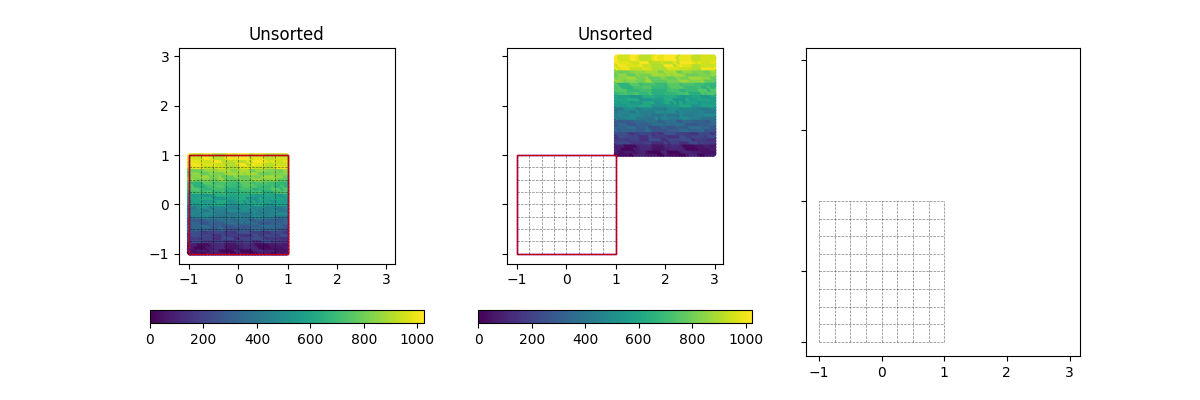

In [61]:
# Visualize the sorting to make sure it worked
fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = True, sharey = True, squeeze = False)

for i in range(numCells[0] + 1):
    for ii in range(3):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(3):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 500 / math.sqrt(x.shape[0])

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = sortIndex, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('Unsorted')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')

sc = axis[0,1].scatter(x[:,0], x[:,1], c = sortIndex, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('Unsorted')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')

sc = axis[0,2].scatter(sortedPositions[:,0], sortedPositions[:,1], s = scatterSize, c = sortedLinear, label = 'Sorted')
fig.colorbar(sc, ax = axis[0,2], orientation='horizontal')
axis[0,2].set_title('Sorted')
axis[0,2].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,2].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,2].set_aspect(1, adjustable='box')



In [22]:
# compact teh list of occupied cells
cellIndices, cellCounters = torch.unique_consecutive(sortedLinear, return_counts=True, return_inverse=False)
cellCounters = cellCounters.to(torch.int32)
# Needs to zero padded for the indexing to work properly as the 0th cell is valid and cumsum doesn't include the first element

cumCell = torch.hstack((torch.tensor([0], device = cellIndices.device, dtype=cellCounters.dtype),torch.cumsum(cellCounters,dim=0)))[:-1]#.to(torch.int32)

# We can now use the cumCell to index into the sortedIndices to get the cell index for each particle
# We could have reversed the linear indices to get the cell index for each cell, but this is more reliable and avoids inverse computations
sortedIndices = torch.floor((sortedPositions - qMin) / hCell).to(torch.int32)
cellGridIndices = sortedIndices[cumCell,:]
# Cell indices contains the linear indices of the particles in each cell
# cellCounters contains the number of particles in each cell
# cumCell contains the cumulative sum of the number of particles in each cell, i.e., the offset into the cell
# With this information we can build a datastructure with [begin, end) for each cell using cellCounters and cumCell!
cellTable = torch.stack((cellIndices, cumCell, cellCounters), dim = 1)


print('cellIndices:', cellIndices.shape, 'cellCounters:', cellCounters.shape, 'cumCell:', cumCell.shape)
print('cellIndices:', cellIndices)
print('cellCounters:', cellCounters)
print('cellTable:', cellTable)
# print('cellGridIndices', cellGridIndices)

cellIndices: torch.Size([64]) cellCounters: torch.Size([64]) cumCell: torch.Size([64])
cellIndices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=torch.int32)
cellCounters: tensor([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16], dtype=torch.int32)
cellTable: tensor([[   0,    0,   16],
        [   1,   16,   16],
        [   2,   32,   16],
        [   3,   48,   16],
        [   4,   64,   16],
        [   5,   80,   16],
        [   6,   96,   16],
        [   7,  112,   16],
        [   8,  128,   16],
       

In [23]:

# Arbitrary size, could be prime, could be other sizes. larger = less collisions but more memory pressure and consumption
hashMapLength = 4096

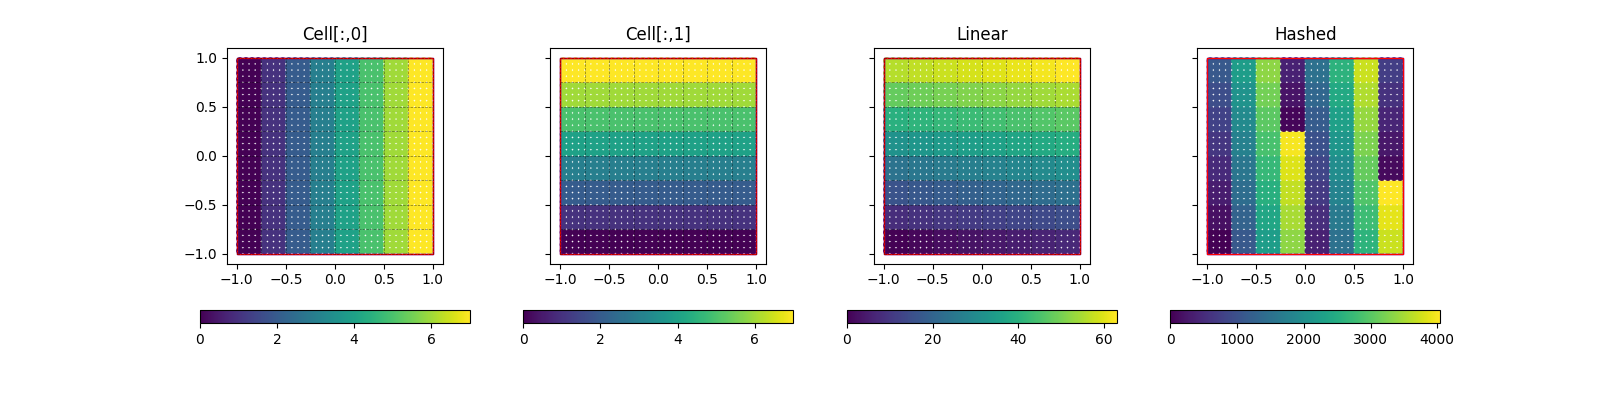

In [24]:
# Visualize the different particle indexing schemes
fig, axis = plt.subplots(1, 4, figsize=(16,4), sharex = True, sharey = True, squeeze = False)


for i in range(numCells[0] + 1):
    for ii in range(3):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(3):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 600 / math.sqrt(x.shape[0])

sc = axis[0,0].scatter(sortedPositions[:,0], sortedPositions[:,1], c = sortedIndices[:,0], s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('Cell[:,0]')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')

sc = axis[0,1].scatter(sortedPositions[:,0], sortedPositions[:,1], c = sortedIndices[:,1], s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('Cell[:,1]')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')


sc = axis[0,2].scatter(sortedPositions[:,0], sortedPositions[:,1], c = sortedLinear, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,2], orientation='horizontal')
axis[0,2].set_title('Linear')
axis[0,2].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,2].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,2].set_aspect(1, adjustable='box')

hashedParticleIndices = hashCellIndices(sortedIndices, hashMapLength)
sc = axis[0,3].scatter(sortedPositions[:,0], sortedPositions[:,1], c = hashedParticleIndices, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,3], orientation='horizontal')
axis[0,3].set_title('Hashed')
axis[0,3].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,3].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,3].set_aspect(1, adjustable='box')


In [25]:
# Hash the cell indices and sort them to get a compact list of occupied cells with unique_consecutive, same as for the cells
hashedIndices = hashCellIndices(cellGridIndices, hashMapLength)
hashIndexSorting = torch.argsort(hashedIndices)
hashMap, hashMapCounters = torch.unique_consecutive(hashedIndices[hashIndexSorting], return_counts=True, return_inverse=False)
hashMapCounters = hashMapCounters.to(torch.int32)
# Resort the entries based on the hashIndexSorting so they can be accessed through the hashmap
sortedCellIndices = cellIndices[hashIndexSorting]
sortedCellTable = torch.stack([c[hashIndexSorting] for c in cellTable.unbind(1)], dim = 1)
print(sortedCellTable)
# sortedCumCell = cellCounters[hashIndexSorting]
# cellSpan = cellTable[hashIndexSorting,0][hashIndexSorting]

# Same construction as for the cell list but this time we create a more direct table
# The table contains the start and length for each cell in the hash table and -1 if the cell is empty
hashTable = hashMap.new_ones(hashMapLength,2) * -1
hashTable[:,1] = 0
hashMap64 = hashMap.to(torch.int64)
hashTable[hashMap64,0] = torch.hstack((torch.tensor([0], device = sortedCellIndices.device, dtype=sortedCellIndices.dtype),torch.cumsum(hashMapCounters,dim=0)))[:-1].to(torch.int32) #torch.cumsum(hashMapCounters, dim = 0) #torch.arange(hashMap.shape[0], device=hashMap.device)

hashTable[hashMap64,1] = hashMapCounters

print(hashTable[hashTable[:,0] != -1].shape)

tensor([[   0,    0,   16],
        [  43,  688,   16],
        [  31,  496,   16],
        [   8,  128,   16],
        [  51,  816,   16],
        [  39,  624,   16],
        [  16,  256,   16],
        [  59,  944,   16],
        [   4,   64,   16],
        [  47,  752,   16],
        [  24,  384,   16],
        [  12,  192,   16],
        [  55,  880,   16],
        [  32,  512,   16],
        [  20,  320,   16],
        [  63, 1008,   16],
        [  40,  640,   16],
        [  28,  448,   16],
        [  48,  768,   16],
        [  36,  576,   16],
        [  56,  896,   16],
        [   1,   16,   16],
        [  44,  704,   16],
        [   9,  144,   16],
        [  52,  832,   16],
        [  17,  272,   16],
        [  60,  960,   16],
        [   5,   80,   16],
        [  25,  400,   16],
        [  13,  208,   16],
        [  33,  528,   16],
        [  21,  336,   16],
        [  41,  656,   16],
        [  29,  464,   16],
        [  49,  784,   16],
        [  37,  592,

In [27]:
# y = torch.clone(x)
# # y = y[0,:].view(1,-1)
# ySupport = supports
# periodicity = [True] * dim


# # queryPosition = torch.tensor([0.0, 0.0], dtype = x.dtype, device = x.device)
# queryPosition = x.min(dim = 0)[0]
# querySupport = ySupport[0]

# print(querySupport)
# print(queryPosition)

# centerCell = torch.floor((queryPosition - qMin) / hCell).to(torch.int32)

# queryCell(centerCell, hashTable, hashMapLength, numCells, sortedCellTable)

# neighbors = findNeighbors(queryPosition, querySupport, 2, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity))

# print('neighbors',len(neighbors), neighbors)

In [29]:
ny = 16
# h = 0.1

# positions = torch.rand(n, 2) * 0.5 + 0.25
dy = dx.item()

xpos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
ypos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
xpos2, ypos2 = torch.meshgrid(xpos2, ypos2, indexing = 'xy')
y = torch.stack((xpos2.flatten(), ypos2.flatten()), dim = 1)
# y = torch.clone(x)
ySupport = torch.ones(y.shape[0]) * supports[0]

periodicity = [False] * dim

In [30]:
i = []
j = []

for index in tqdm(range(y.shape[0])):
    neighborhood = findNeighbors(y[index,:], ySupport[index], 1, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity))
    i.append(torch.ones(neighborhood.shape[0], dtype = torch.int32) * index)
    j.append(neighborhood)

i = torch.hstack(i)
j = sortIndex[torch.hstack(j)]

print(i.shape, j.shape)
print('i:', i.min(), i.max())
print('j:', j.min(), j.max())

ii, nit = torch.unique(i, return_counts=True)
ni = torch.zeros(y.shape[0], dtype = nit.dtype, device = x.device)
print('ni:', nit.shape, nit.min(), nit.max(), nit.sum(), nit)
ni[ii] = nit
# print(ii, ni)
jj, njt = torch.unique(j, return_counts=True)
nj = torch.zeros(x.shape[0], dtype = njt.dtype, device = y.device)
print('nj:', njt.shape, njt.min(), njt.max(), njt.sum(), njt)
nj[jj] = njt
# print(jj, nj)


  0%|          | 0/256 [00:00<?, ?it/s]

torch.Size([11520]) torch.Size([11520])
i: tensor(0, dtype=torch.int32) tensor(255, dtype=torch.int32)
j: tensor(166) tensor(857)
ni: torch.Size([256]) tensor(45) tensor(45) tensor(11520) tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 

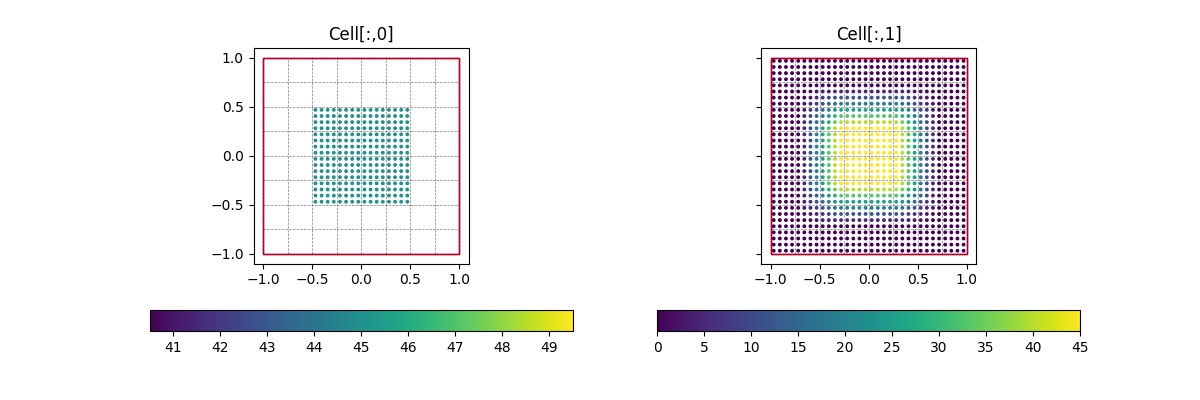

In [31]:
fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = True, sharey = True, squeeze = False)


for i in range(numCells[0] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].vlines(x = qMin[0] + i * hCell, ymin = qMin[1], ymax = qMax[1], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
for i in range(numCells[1] + 1):
    for ii in range(axis.shape[1]):
        axis[0,ii].hlines(y = qMin[1] + i * hCell, xmin = qMin[0], xmax = qMax[0], color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)

scatterSize = 100 / math.sqrt(x.shape[0])

sc = axis[0,0].scatter(y[:,0], y[:,1], c = ni, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,0], orientation='horizontal')
axis[0,0].set_title('Cell[:,0]')
axis[0,0].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,0].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,0].set_aspect(1, adjustable='box')

sc = axis[0,1].scatter(x[:,0], x[:,1], c = nj, s = scatterSize, label = 'Unsorted')
fig.colorbar(sc, ax = axis[0,1], orientation='horizontal')
axis[0,1].set_title('Cell[:,1]')
axis[0,1].add_patch(patches.Rectangle((minDomain[0], minDomain[1]), maxDomain[0] - minDomain[0], maxDomain[1] - minDomain[1], fill=False, edgecolor='b', linewidth = 1))
axis[0,1].add_patch(patches.Rectangle((qMin[0], qMin[1]), qMax[0] - qMin[0], qMax[1] - qMin[1], fill=False, edgecolor='r', linewidth = 1))
axis[0,1].set_aspect(1, adjustable='box')